In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import roc_auc_score ,roc_curve,auc
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import collections
import math

In [3]:
import warnings
warnings.filterwarnings("ignore")

## 1. Функции для расчета энтропии и прироста информации (5 баллов)

Пример для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [4]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [5]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [6]:
def entropy(dna_sequence):
    m = len(dna_sequence)
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
 
    shannon_entropy_value = 0
    for base in bases:
        n_i = bases[base]
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
 
    return shannon_entropy_value * -1

Проверка

In [7]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


Чему равна энтропия состояния, заданного списком `balls_left`?

Ответ: 0.96

Чему равна энтропия игральной кости с несмещенным центром тяжести?

Ответ: 2.58

In [8]:
# расчет прироста информации
def information_gain(root, left, right):

    original_entropy = entropy(root)
    
    N = len(root)
    
    left_entropy = entropy(left)
    
    n1 = len(left)
    
    right_entropy = entropy(right)
    
    n2 = len(right)

    return original_entropy - n1/N * left_entropy - n2/N * right_entropy

Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [9]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [10]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    
    feature_ent = []
    for col in X.columns:
        for val in X[col].unique():
            left = [y[j] for j in range(len(y)) if X[col][j] <= val]
            right = [y[j] for j in range(len(y)) if X[col][j] > val]
            feature_ent.append(information_gain(y, left, right))
    return feature_ent

In [11]:
df_balls = pd.DataFrame(range(len(balls)), columns=["Feature 1"])

In [12]:
best_feature_to_split(df_balls, balls)

[0.05993070646691567,
 0.12510356566040215,
 0.19660717939188022,
 0.27594386796016235,
 0.36529389753193287,
 0.4680577739061724,
 0.5901760274466119,
 0.7444843438056281,
 0.9927744539878084,
 0.7582766571931678,
 0.6165533143863354,
 0.5060075793123286,
 0.413954887845139,
 0.33457428291836677,
 0.264561508146807,
 0.20181492735701034,
 0.14489728957406045,
 0.09277445398780837,
 0.044673614309123866,
 0.0]

## 2. Деревья решений на наборе данных Adult (10 баллов)

**Описание набора:**

https://archive.ics.uci.edu/ml/datasets/adult (для ознакомления, а сами данные adult_train, adult_test располагаются в папке datasets на нашем GitHub):

Классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более 50 000 \$ в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [13]:
# если в Jupyter Notebook:

data_train = pd.read_csv('adult_train.csv', sep=';') 

In [14]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [15]:
data_test = pd.read_csv('adult_test.csv', sep=';') 

In [16]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [17]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первичный анализ данных.**

In [18]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

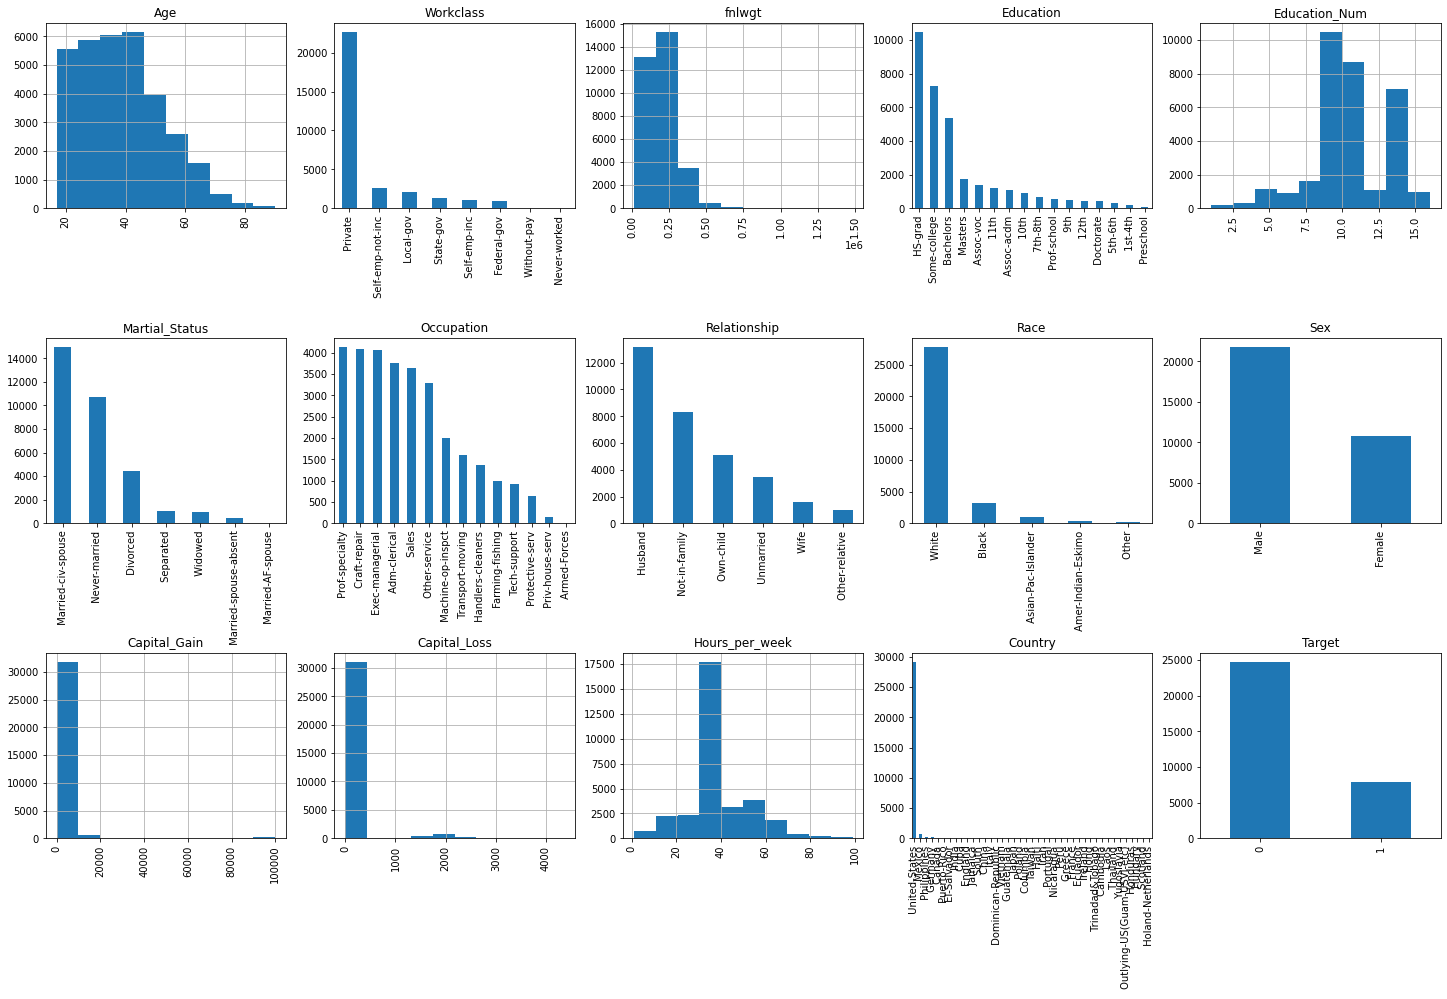

In [20]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(data_train.shape[1] / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [21]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [22]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [23]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [24]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [25]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [26]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

Проверяем остались ли у нас пропуски в данных

data_test.isna().sum().sum()

data_train.isna().sum().sum()

data_train = data_train.dropna()
data_test = data_test.dropna()

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [27]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [28]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [29]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [30]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [31]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [32]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [33]:
set(data_train.columns) - set(data_test.columns)

set()

In [34]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [36]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 2.1. Дерево решений без настройки параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [37]:
tree = DecisionTreeClassifier(max_depth = 3, random_state = 17)
tree = tree.fit(X_train , y_train)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [38]:
tree_predictions = tree.predict(X_test) 

In [39]:
accuracy_score = metrics.accuracy_score(y_test, tree_predictions)
accuracy_score

0.8447884036607088

Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

Ответ: 0.84

## 2.2. Дерево решений с настройкой параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`.**

In [44]:
tree_clas = DecisionTreeClassifier(random_state=17)

In [45]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(estimator=tree_clas, param_grid=tree_params)                   

locally_best_tree.fit(X_train , y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [46]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [47]:
tuned_tree = DecisionTreeClassifier(max_depth = 9, random_state = 17)
tuned_tree.fit(X_train , y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, tuned_tree_predictions)
accuracy_score

0.8471838339168356

Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

0.85

# 3. Логистическая регрессия в задаче кредитного скоринга (15 баллов)



#### Данные представлены следующим образом (credit_scoring_sample из наших datasets на GitHub):

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [88]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [89]:
## Считываем данные 

data = pd.read_csv("credit_scoring_sample.csv", sep=";") # прописать путь в ависимости от того, где выполняете работу
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [90]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

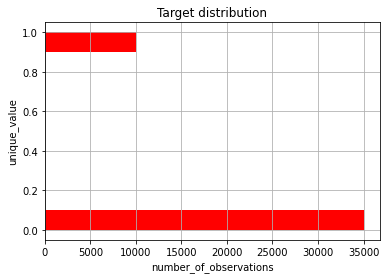

In [91]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [92]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [93]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = data.fillna(data.median())

Проверяем не осталось ли пропусков 

In [94]:
table.isna().sum().sum()

0

In [95]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Используем модуль LogisticRegression для построения логистической регрессии.
# Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
# Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

# Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
# Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
# и будет хорошо предсказывать значения таргета, с другой.
# Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

# Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
# значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [97]:
 # Побираем оптимальные гиперпараметры а также выводит наивысшее значение roc-auc

clf = GridSearchCV(lr, parameters,scoring='roc_auc', cv=skf)
clf.fit(X,y)
print('Best roc-auc score: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc-auc score: 0.8089, with best C: {'C': 0.001}


In [98]:
# Можем посмотерть более детально 
roc_dict = dict()

C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
for c in C:
    final_scores = []
    mean_scores = {}
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print("Fold:" , fold +1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        lr.fit(X_train,y_train)
        predictions = clf.predict_proba(X_train)[:,1]
        final_scores.append(roc_auc_score(y_train, predictions))
        print("AUC SCORE:" + str(roc_auc_score(y_train, predictions)))
    roc_dict[c] = np.mean(final_scores)

Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
Fold: 3
AUC SCORE:0.7940812190892729
Fold: 4
AUC SCORE:0.7956417138689142
Fold: 5
AUC SCORE:0.7923445848511376
Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
Fold: 3
AUC SCORE:0.7940812190892729
Fold: 4
AUC SCORE:0.7956417138689142
Fold: 5
AUC SCORE:0.7923445848511376
Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
Fold: 3
AUC SCORE:0.7940812190892729
Fold: 4
AUC SCORE:0.7956417138689142
Fold: 5
AUC SCORE:0.7923445848511376
Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
Fold: 3
AUC SCORE:0.7940812190892729
Fold: 4
AUC SCORE:0.7956417138689142
Fold: 5
AUC SCORE:0.7923445848511376
Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
Fold: 3
AUC SCORE:0.7940812190892729
Fold: 4
AUC SCORE:0.7956417138689142
Fold: 5
AUC SCORE:0.7923445848511376
Fold: 1
AUC SCORE:0.7945279562871391
Fold: 2
AUC SCORE:0.7928684131444551
F

In [106]:
# Можно ли считать лучшую модель устойчивой? 
# (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) 
print(clf.cv_results_['std_test_score'][1])

0.008137559189742445


Нет, модель не учтойчивая (стандартное отклонение равно 0.8% > 0.5%)

In [109]:
# Наши лучшее значение точности на валидации

roc_auc_LogisticRegression =  clf.best_score_
roc_auc_LogisticRegression

0.8089120626797153

## 3.1 Определение влияния признаков (5 баллов) 

Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
#нормализую признаки
scaler = StandardScaler()
Xstan = scaler.fit_transform(X)

In [67]:
#вывожу коэффициенты и константу 
lr_best = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
lr_best.fit(Xstan, y)
print(lr_best.coef_, lr_best.intercept_)

[[-0.41670229  0.72342698 -0.02409605  0.51678764  0.19355764 -0.16314632
   0.1014432 ]] [-0.03195876]


In [68]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': lr_best.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

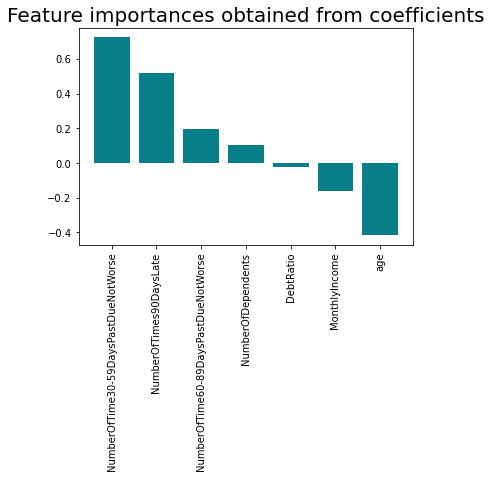

In [69]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

Итак, самый большой коэффициент по модулю равен - 0.72 (при переменной NumberOfTime30-59DaysPastDueNotWorse). Можно говорить о том, что сильнее всего на нашу зависимую переменню - выплату кредита  влияет переменная NumberOfTime30-59DaysPastDueNotWorse.

In [71]:
# Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)
from scipy.special import softmax

share = softmax(lr_best.coef_)[0]
share[2]

0.11426375283065268

# 4. Случайный лес (5 баллов) 

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же k-fold валидацию. 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [79]:
# Побираем гипермараметры с помощью сетки для модели
rf_cv = GridSearchCV(rf, parameters, scoring='roc_auc', cv=skf)
rf_cv.fit(X,y)
rf_cv.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [111]:
# Насколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?
# Значение roc-auc score на валидации у модели с подобраннами оптимальными гиперпараметрами 

roc_auc_RandomForestClassifier = rf_cv.best_score_
roc_auc_RandomForestClassifier

0.8357785451032532

In [113]:
# разница между roc-auc score для случайного леса и логистической регресии
roc_auc_RandomForestClassifier - roc_auc_LogisticRegression

0.026866482423537952

Можем сделать вывод о том, что модель случайного леса обладает более высокой точностью на валидации (точность - 83,6 %) по сравнению с моделью логистической регресии (80,9%). Разница составляет 2,7%

In [114]:
rf_fin = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
    max_depth=10,
    max_features=2,
    min_samples_leaf=9
)

rf_fin.fit(Xstan,y)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, n_jobs=-1, oob_score=True,
                       random_state=42)

In [115]:
# Какой признак имеет наименьшее влияние?

rf_fin.feature_importances_

array([0.11692002, 0.29839147, 0.07576508, 0.28020337, 0.15617728,
       0.05786662, 0.01467616])

<BarContainer object of 7 artists>

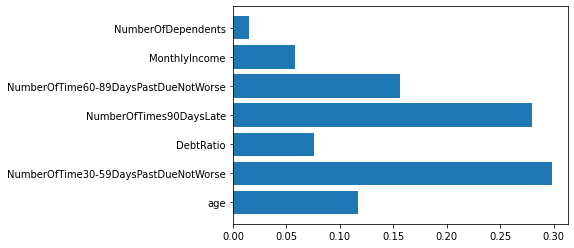

In [116]:
plt.barh(list(X), rf_fin.feature_importances_)

Можем сделать вывод о том, что наименьшее влияние оказывает признак: NumberOfDependents